In [8]:
import warnings
warnings.filterwarnings('ignore')

# Mongo
from pymongo import MongoClient

# Pandas and numpy
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None

# Statsmodel
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plotting
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from pandas.plotting import autocorrelation_plot
import seaborn as sns
sns.set(rc={'figure.figsize':(18, 4)})
plt.style.use('ggplot')

# Other
from scipy.ndimage.filters import gaussian_filter1d
from IPython.display import Image
from datetime import datetime, timedelta
from math import sqrt
from sklearn.metrics import mean_squared_error

import logging, os
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3" 

In [2]:
# Mongo client
client = MongoClient('mongodb://165.22.199.122:27017')
db = client.processed
data = db.external

In [3]:
# Load the data
df= (pd.DataFrame(list(data.find()))
    .drop('_id', 1)
    .set_index('timestamp')
    .sort_index()
    .dropna())

df.head()

,n_tweets,price,sentiment
timestamp,,,
2017-08-02 05:00:00,509.0,2735.27,0.068275
2017-08-02 06:00:00,892.0,2732.12,0.076942
2017-08-02 07:00:00,830.0,2731.96,0.080092
2017-08-02 08:00:00,819.0,2710.21,0.082844
2017-08-02 09:00:00,1196.0,2719.31,0.087544


In [4]:
# Differencing the log values
price_diff = df['price'].diff().dropna()
pd.DataFrame(price_diff.head())

,price
timestamp,
2017-08-02 06:00:00,-3.15
2017-08-02 07:00:00,-0.16
2017-08-02 08:00:00,-21.75
2017-08-02 09:00:00,9.10
2017-08-02 10:00:00,13.68


In [5]:
# Using the Dickey-Fuller test to check for stationarity
results = adfuller(price_diff)
print('P-value: {}'.format(results[1]))

P-value: 2.3494362695911308e-30


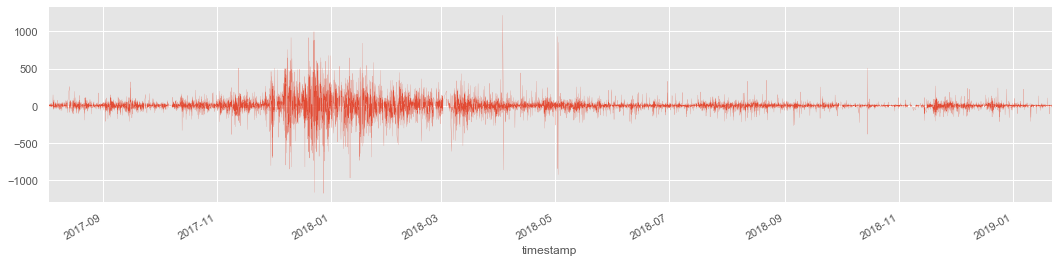

In [9]:
price_diff.plot(linewidth=.15);

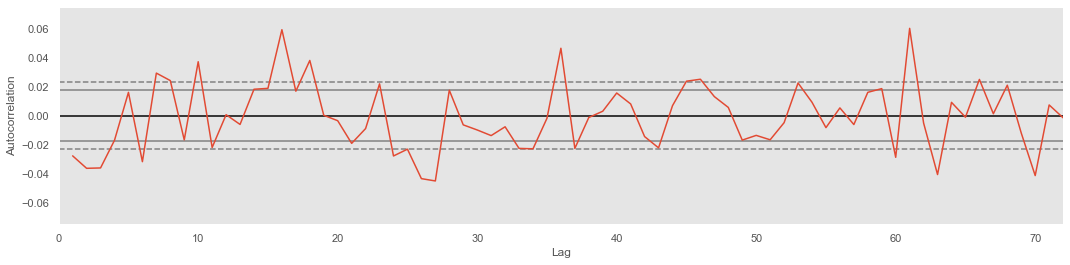

In [10]:
autocorrelation_plot(price_diff)
plt.xlim([0,72])
plt.ylim([-.075,.075]);

In [ ]:
!pip install fbprophet plotly -q

In [15]:
import plotly
from fbprophet import Prophet as proph

In [22]:
df_prophet = df.drop(['n_tweets', 'sentiment'], 1).rename({'price': 'y'}, axis=1)
df_prophet['ds'] = df_prophet.index
df_prophet.head()

,y,ds
timestamp,,
2017-08-02 05:00:00,2735.27,2017-08-02 05:00:00
2017-08-02 06:00:00,2732.12,2017-08-02 06:00:00
2017-08-02 07:00:00,2731.96,2017-08-02 07:00:00
2017-08-02 08:00:00,2710.21,2017-08-02 08:00:00
2017-08-02 09:00:00,2719.31,2017-08-02 09:00:00


In [23]:
# Fitting and training
mod = proph(interval_width=0.95)
mod.fit(df_prophet)

In [58]:
# Setting up predictions to be made
future = mod.make_future_dataframe(periods=720, freq='H')
future.tail()

,ds
13053,2019-02-20 19:00:00
13054,2019-02-20 20:00:00
13055,2019-02-20 21:00:00
13056,2019-02-20 22:00:00
13057,2019-02-20 23:00:00


In [63]:
# Making predictions
forecast = mod.predict(future)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
13053,2019-02-20 19:00:00,1949.701611,-4957.166775,8794.741213,-4881.449422,8429.730444,11.900127,11.900127,11.900127,2.567877,2.567877,2.567877,9.332250,9.332250,9.332250,0.0,0.0,0.0,1961.601737
13054,2019-02-20 20:00:00,1948.272273,-5238.454304,8943.684308,-4898.627894,8440.954299,15.768874,15.768874,15.768874,7.699168,7.699168,7.699168,8.069706,8.069706,8.069706,0.0,0.0,0.0,1964.041147
13055,2019-02-20 21:00:00,1946.842935,-5028.005117,8844.758432,-4915.806366,8452.178154,21.146961,21.146961,21.146961,14.585947,14.585947,14.585947,6.561014,6.561014,6.561014,0.0,0.0,0.0,1967.989896
13056,2019-02-20 22:00:00,1945.413597,-4852.772885,8551.730952,-4932.984838,8463.402009,23.807387,23.807387,23.807387,19.000587,19.000587,19.000587,4.806799,4.806799,4.806799,0.0,0.0,0.0,1969.220983
13057,2019-02-20 23:00:00,1943.984259,-5096.288042,8866.396815,-4950.163310,8474.625865,20.976902,20.976902,20.976902,18.166037,18.166037,18.166037,2.810865,2.810865,2.810865,0.0,0.0,0.0,1964.961161


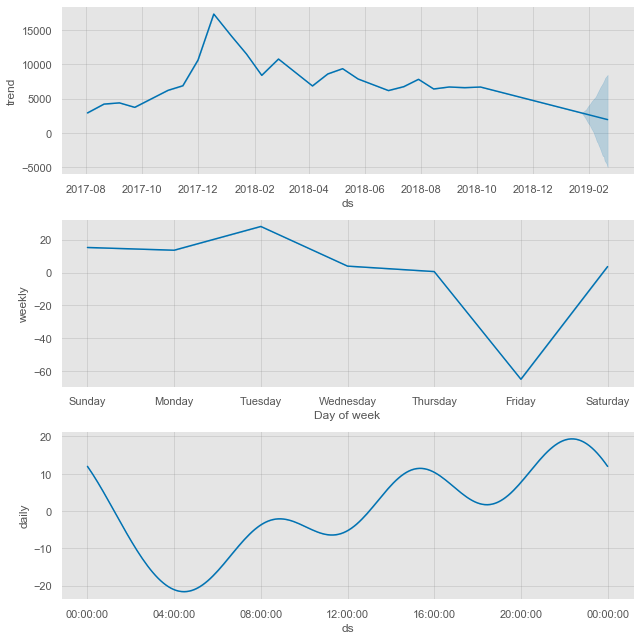

In [64]:
mod.plot_components(forecast)
plt.show()

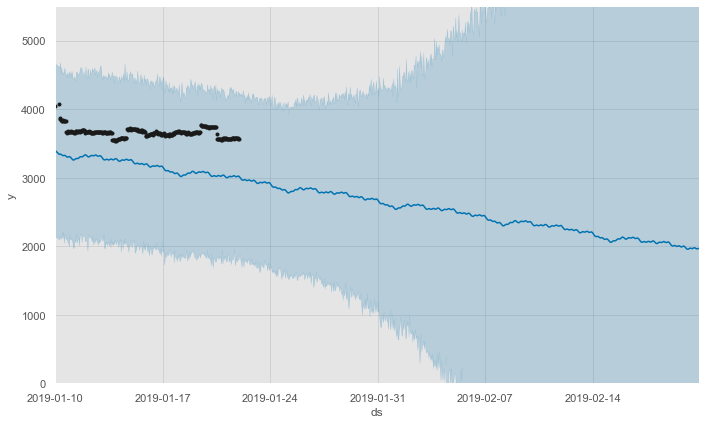

In [68]:
mod.plot(forecast, uncertainty=True)

plt.xlim([datetime.strptime('2019-01-10 00:00:00', '%Y-%m-%d %X'), future.iloc[-1,0]])
plt.ylim([0, 5500])
plt.show()

### Arima

In [12]:
from statsmodels.tsa.arima_model import ARIMA

                             ARIMA Model Results                              
Dep. Variable:               D2.price   No. Observations:                12335
Model:                ARIMA(10, 2, 0)   Log Likelihood              -76571.474
Method:                       css-mle   S.D. of innovations            120.126
Date:                Sun, 10 Nov 2019   AIC                         153166.947
Time:                        12:27:52   BIC                         153255.990
Sample:                             2   HQIC                        153196.776
                                                                              
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const           -9.773e-06      0.067     -0.000      1.000      -0.132       0.132
ar.L1.D2.price     -1.6857      0.009   -190.198      0.000      -1.703      -1.668
ar.L2.D2.price     -2.1015      

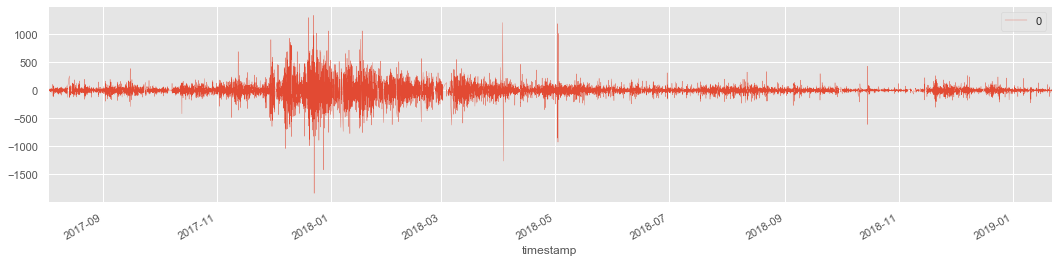

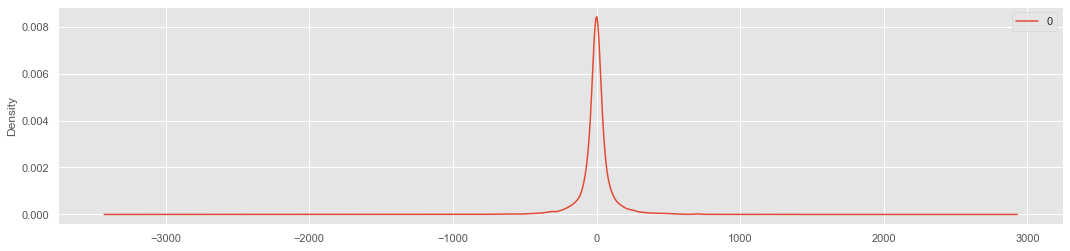

                  0
count  12335.000000
mean      -0.000836
std      120.131446
min    -1838.447129
25%      -30.661021
50%       -0.100553
75%       30.351254
max     1339.913585


In [48]:
# Fit model
model = ARIMA(price_diff, order=(10,2,0))
model_fit = model.fit(disp=1)
print(model_fit.summary())

# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot(linewidth=.3)
plt.show()

residuals.plot(kind='kde')
plt.show()

print(residuals.describe())

In [73]:
X = price_diff.iloc[:].values
size = int(len(X) * 0.997)
train, test = X[:size], X[size:]
print(len(test))
history = list(train)
predictions = list()

for t in range(len(test)):
    model = ARIMA(history, order=(8,1,0))
    model_fit = model.fit(disp=1)
    
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    
    print('predicted=%f, expected=%f' % (yhat, obs))

38
predicted=0.991675, expected=-3.700000
predicted=-0.097767, expected=7.070000
predicted=-0.756936, expected=-110.700000
predicted=-9.561953, expected=-73.210000
predicted=-15.738323, expected=10.290000
predicted=-14.899224, expected=-1.070000
predicted=-16.776869, expected=-4.230000
predicted=-22.914287, expected=3.930000
predicted=-19.393315, expected=-7.160000
predicted=-22.774897, expected=-3.730000
predicted=-26.728922, expected=-2.630000
predicted=-21.287924, expected=15.420000
predicted=-5.761506, expected=5.340000
predicted=0.619361, expected=4.100000
predicted=0.519284, expected=-10.440000
predicted=-0.098115, expected=5.380000
predicted=1.306670, expected=-1.040000
predicted=0.484490, expected=1.250000
predicted=2.106221, expected=-4.240000
predicted=1.900444, expected=-6.180000
predicted=1.833010, expected=4.080000
predicted=-0.533530, expected=1.830000
predicted=-0.695959, expected=-2.080000
predicted=-1.251223, expected=-4.310000
predicted=-0.656309, expected=-2.420000
p

In [74]:
def predict_roll(data):
    return sqrt(mean_squared_error(np.roll(data, 1)[1:], data[1:]))

print('Test baseline roll: ${:.2f}'.format(predict_roll(test)))
print('Test RMSE: ${:.2f}'.format(sqrt(mean_squared_error(test, predictions))))

Test baseline roll: $26.36
Test RMSE: $23.97


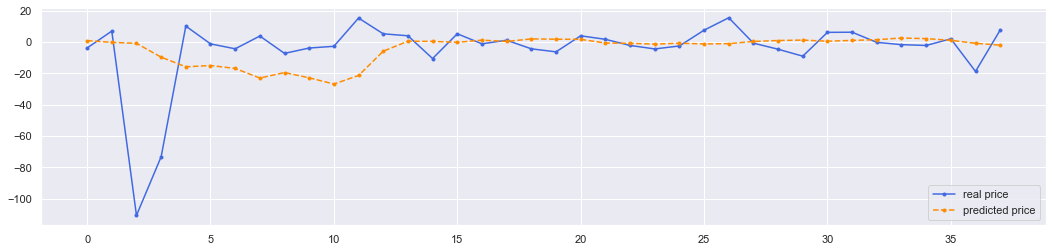

In [75]:
sns.set(style='darkgrid')
plt.plot(test, label='real price', color='royalblue', marker='o', markersize=3)
plt.plot(predictions, linestyle='dashed', color='darkorange', label='predicted price', marker='o', markersize=3);
plt.legend();